In [1]:
import pandas as pd

In [2]:
# data = pd.read_csv("us-counties-2020.csv")

# data.columns

In [3]:
import pandas as pd

# Load the data
file_path = 'us-counties-2020.csv'
data = pd.read_csv(file_path)

# Convert 'date' to datetime format and sort the data
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by=['county', 'state', 'date'], inplace=True)

# Calculate daily new cases and deaths
data['new_cases'] = data.groupby(['county', 'state'])['cases'].diff().fillna(0)
data['new_deaths'] = data.groupby(['county', 'state'])['deaths'].diff().fillna(0)

# Calculate the 7-day rolling averages for new cases and new deaths
data['rolling_avg_new_cases'] = data.groupby(['county', 'state'])['new_cases'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
data['rolling_avg_new_deaths'] = data.groupby(['county', 'state'])['new_deaths'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Replace zeros in rolling averages to avoid division by zero in percentage calculations
data['rolling_avg_new_cases'].replace(0, 0.01, inplace=True)
data['rolling_avg_new_deaths'].replace(0, 0.01, inplace=True)

# Calculate the percentage change in the 7-day rolling averages
data['pct_change_cases'] = data.groupby(['county', 'state'])['rolling_avg_new_cases'].pct_change(periods=7) * 100
data['pct_change_deaths'] = data.groupby(['county', 'state'])['rolling_avg_new_deaths'].pct_change(periods=7) * 100

# Calculate median increase rates to set thresholds
median_pct_change_cases = data['pct_change_cases'].median()
median_pct_change_deaths = data['pct_change_deaths'].median()

# Define thresholds for significant increases
threshold_cases = 10  # 10% increase for cases
threshold_deaths = 5  # 5% increase for deaths

# Identify counties with significant increases based on the latest data
significant_cases = data[data['pct_change_cases'] > threshold_cases]
significant_deaths = data[data['pct_change_deaths'] > threshold_deaths]

# Select only the latest date entries for these counties
latest_significant_cases = significant_cases.loc[significant_cases.groupby(['county', 'state'])['date'].idxmax()]
latest_significant_deaths = significant_deaths.loc[significant_deaths.groupby(['county', 'state'])['date'].idxmax()]

# Display results
# print(latest_significant_cases[['date', 'county', 'state', 'pct_change_cases']])
# print(latest_significant_deaths[['date', 'county', 'state', 'pct_change_deaths']])


C:\Users\amith\AppData\Local\Temp\ipykernel_18532\3467724059.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['rolling_avg_new_cases'].replace(0, 0.01, inplace=True)
C:\Users\amith\AppData\Local\Temp\ipykernel_18532\3467724059.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

             date     county           state  pct_change_cases
861190 2020-12-24  Abbeville  South Carolina         20.588235
882612 2020-12-31     Acadia       Louisiana         10.526316
881170 2020-12-30   Accomack        Virginia         23.943662
826878 2020-12-14        Ada           Idaho         16.312317
862816 2020-12-25      Adair            Iowa         28.125000
...           ...        ...             ...               ...
871866 2020-12-28       Yuma         Arizona         36.595451
881799 2020-12-31       Yuma        Colorado         40.740741
838934 2020-12-17     Zapata           Texas        154.929577
874631 2020-12-28     Zavala           Texas        152.941176
880771 2020-12-30    Ziebach    South Dakota         60.000000

[3258 rows x 4 columns]
             date     county           state  pct_change_deaths
883905 2020-12-31  Abbeville  South Carolina        2757.142857
879367 2020-12-30     Acadia       Louisiana         220.000000
858455 2020-12-23   Accomac

In [4]:
# Calculate a 14-day rolling average for the significant increase data to smooth out the daily fluctuations
data['14d_rolling_avg_cases'] = data.groupby(['county', 'state'])['new_cases'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
data['14d_rolling_avg_deaths'] = data.groupby(['county', 'state'])['new_deaths'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# Find the date of the maximum 14-day rolling average increase for cases and deaths
max_increase_cases = data.loc[data['14d_rolling_avg_cases'].idxmax()]
max_increase_deaths = data.loc[data['14d_rolling_avg_deaths'].idxmax()]

# Calculate potential lockdown periods starting a few days before the peaks and lasting until decreases
lockdown_start_cases = max_increase_cases['date'] - pd.Timedelta(days=5)
lockdown_end_cases = max_increase_cases['date'] + pd.Timedelta(days=14)

lockdown_start_deaths = max_increase_deaths['date'] - pd.Timedelta(days=5)
lockdown_end_deaths = max_increase_deaths['date'] + pd.Timedelta(days=14)

(lockdown_start_cases, lockdown_end_cases), (lockdown_start_deaths, lockdown_end_deaths), max_increase_cases['county'], max_increase_deaths['county']


((Timestamp('2020-12-24 00:00:00'), Timestamp('2021-01-12 00:00:00')),
 (Timestamp('2020-04-14 00:00:00'), Timestamp('2020-05-03 00:00:00')),
 'Los Angeles',
 'New York City')

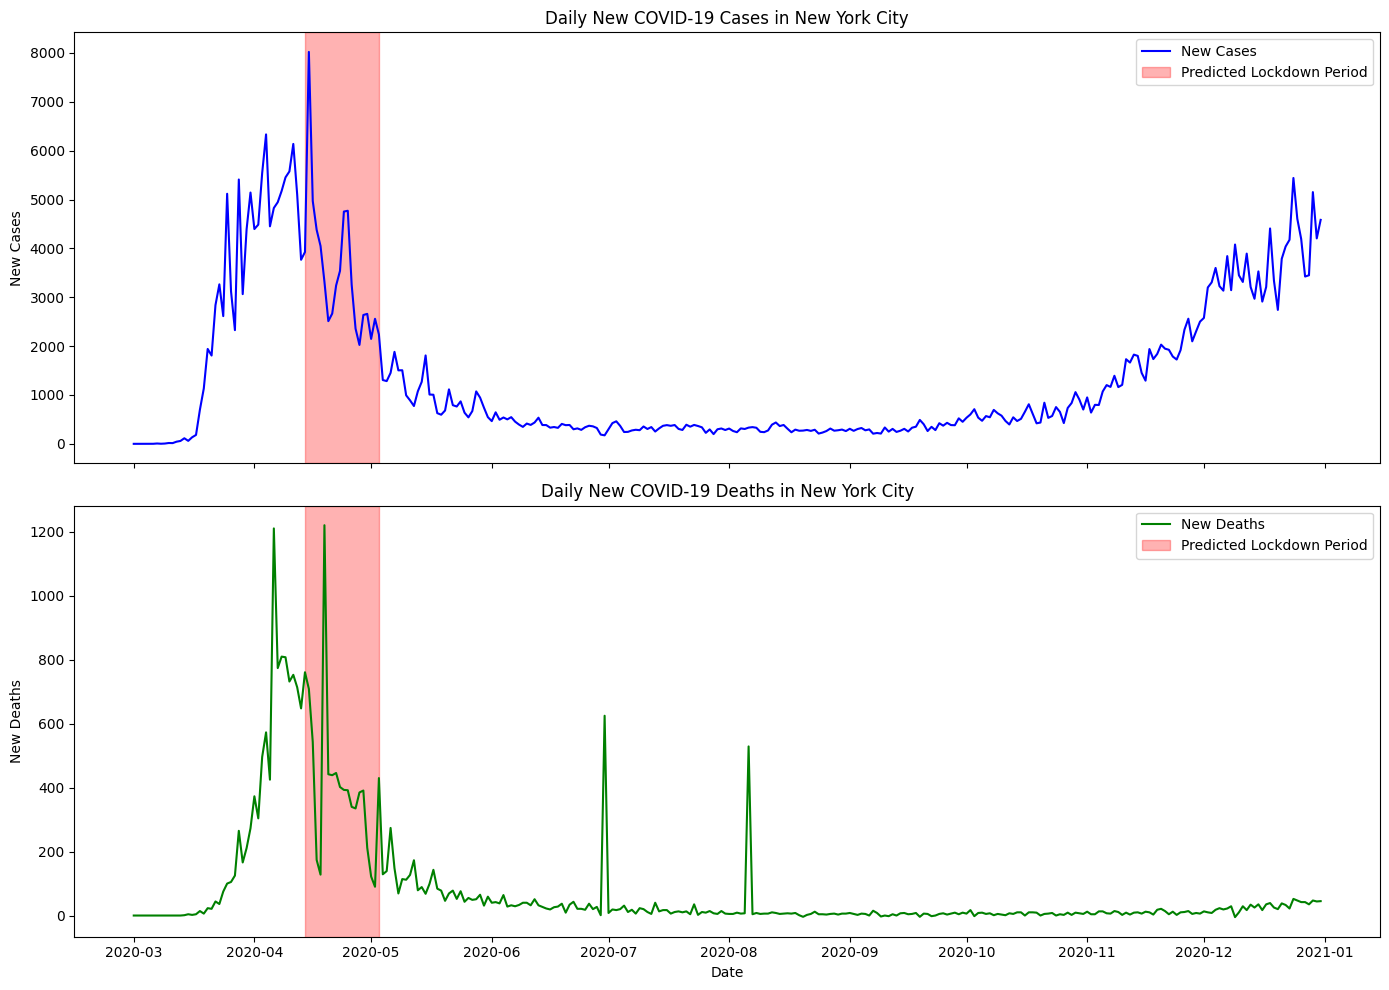

In [5]:
import matplotlib.pyplot as plt

# Filter data for New York City for plotting
nyc_data = data[(data['state'] == 'New York') & (data['county'] == 'New York City')]

# Plotting cases and deaths along with the lockdown period
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot new cases
ax[0].plot(nyc_data['date'], nyc_data['new_cases'], label='New Cases', color='blue')
ax[0].axvspan(lockdown_start_deaths, lockdown_end_deaths, color='red', alpha=0.3, label='Predicted Lockdown Period')
ax[0].set_title('Daily New COVID-19 Cases in New York City')
ax[0].set_ylabel('New Cases')
ax[0].legend()

# Plot new deaths
ax[1].plot(nyc_data['date'], nyc_data['new_deaths'], label='New Deaths', color='green')
ax[1].axvspan(lockdown_start_deaths, lockdown_end_deaths, color='red', alpha=0.3, label='Predicted Lockdown Period')
ax[1].set_title('Daily New COVID-19 Deaths in New York City')
ax[1].set_ylabel('New Deaths')
ax[1].set_xlabel('Date')
ax[1].legend()

plt.tight_layout()
plt.show()


In [9]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [12]:
import plotly.graph_objects as go

# Identify the top 5 counties with the highest significant increases in cases and deaths
top_cases = data.nlargest(5, 'pct_change_cases')
top_deaths = data.nlargest(5, 'pct_change_deaths')

# Create subplots for cases and deaths
fig = go.Figure()

# Add traces for cases
for i, row in top_cases.iterrows():
    fig.add_trace(go.Scatter(x=row['date'], y=row['new_cases'], mode='lines', name=f"{row['county']}, {row['state']}"))

# Add traces for deaths
for i, row in top_deaths.iterrows():
    fig.add_trace(go.Scatter(x=row['date'], y=row['new_deaths'], mode='lines', name=f"{row['county']}, {row['state']}"))

# Add vertical lines for predicted lockdown periods
fig.add_vrect(x0=lockdown_start_cases, x1=lockdown_end_cases, line_width=0, fillcolor="rgba(255,0,0,0.3)", layer="below", name="Lockdown Period (Cases)")
fig.add_vrect(x0=lockdown_start_deaths, x1=lockdown_end_deaths, line_width=0, fillcolor="rgba(255,0,0,0.3)", layer="below", name="Lockdown Period (Deaths)")

# Update layout
fig.update_layout(title="Top 5 Counties with Highest Significant Increases in Cases and Deaths",
                  xaxis_title="Date",
                  yaxis_title="Count",
                  template="plotly_dark")

# Show plot
fig.show()


ValueError: 
    Invalid value of type 'pandas._libs.tslibs.timestamps.Timestamp' received for the 'x' property of scatter
        Received value: Timestamp('2020-12-22 00:00:00')

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

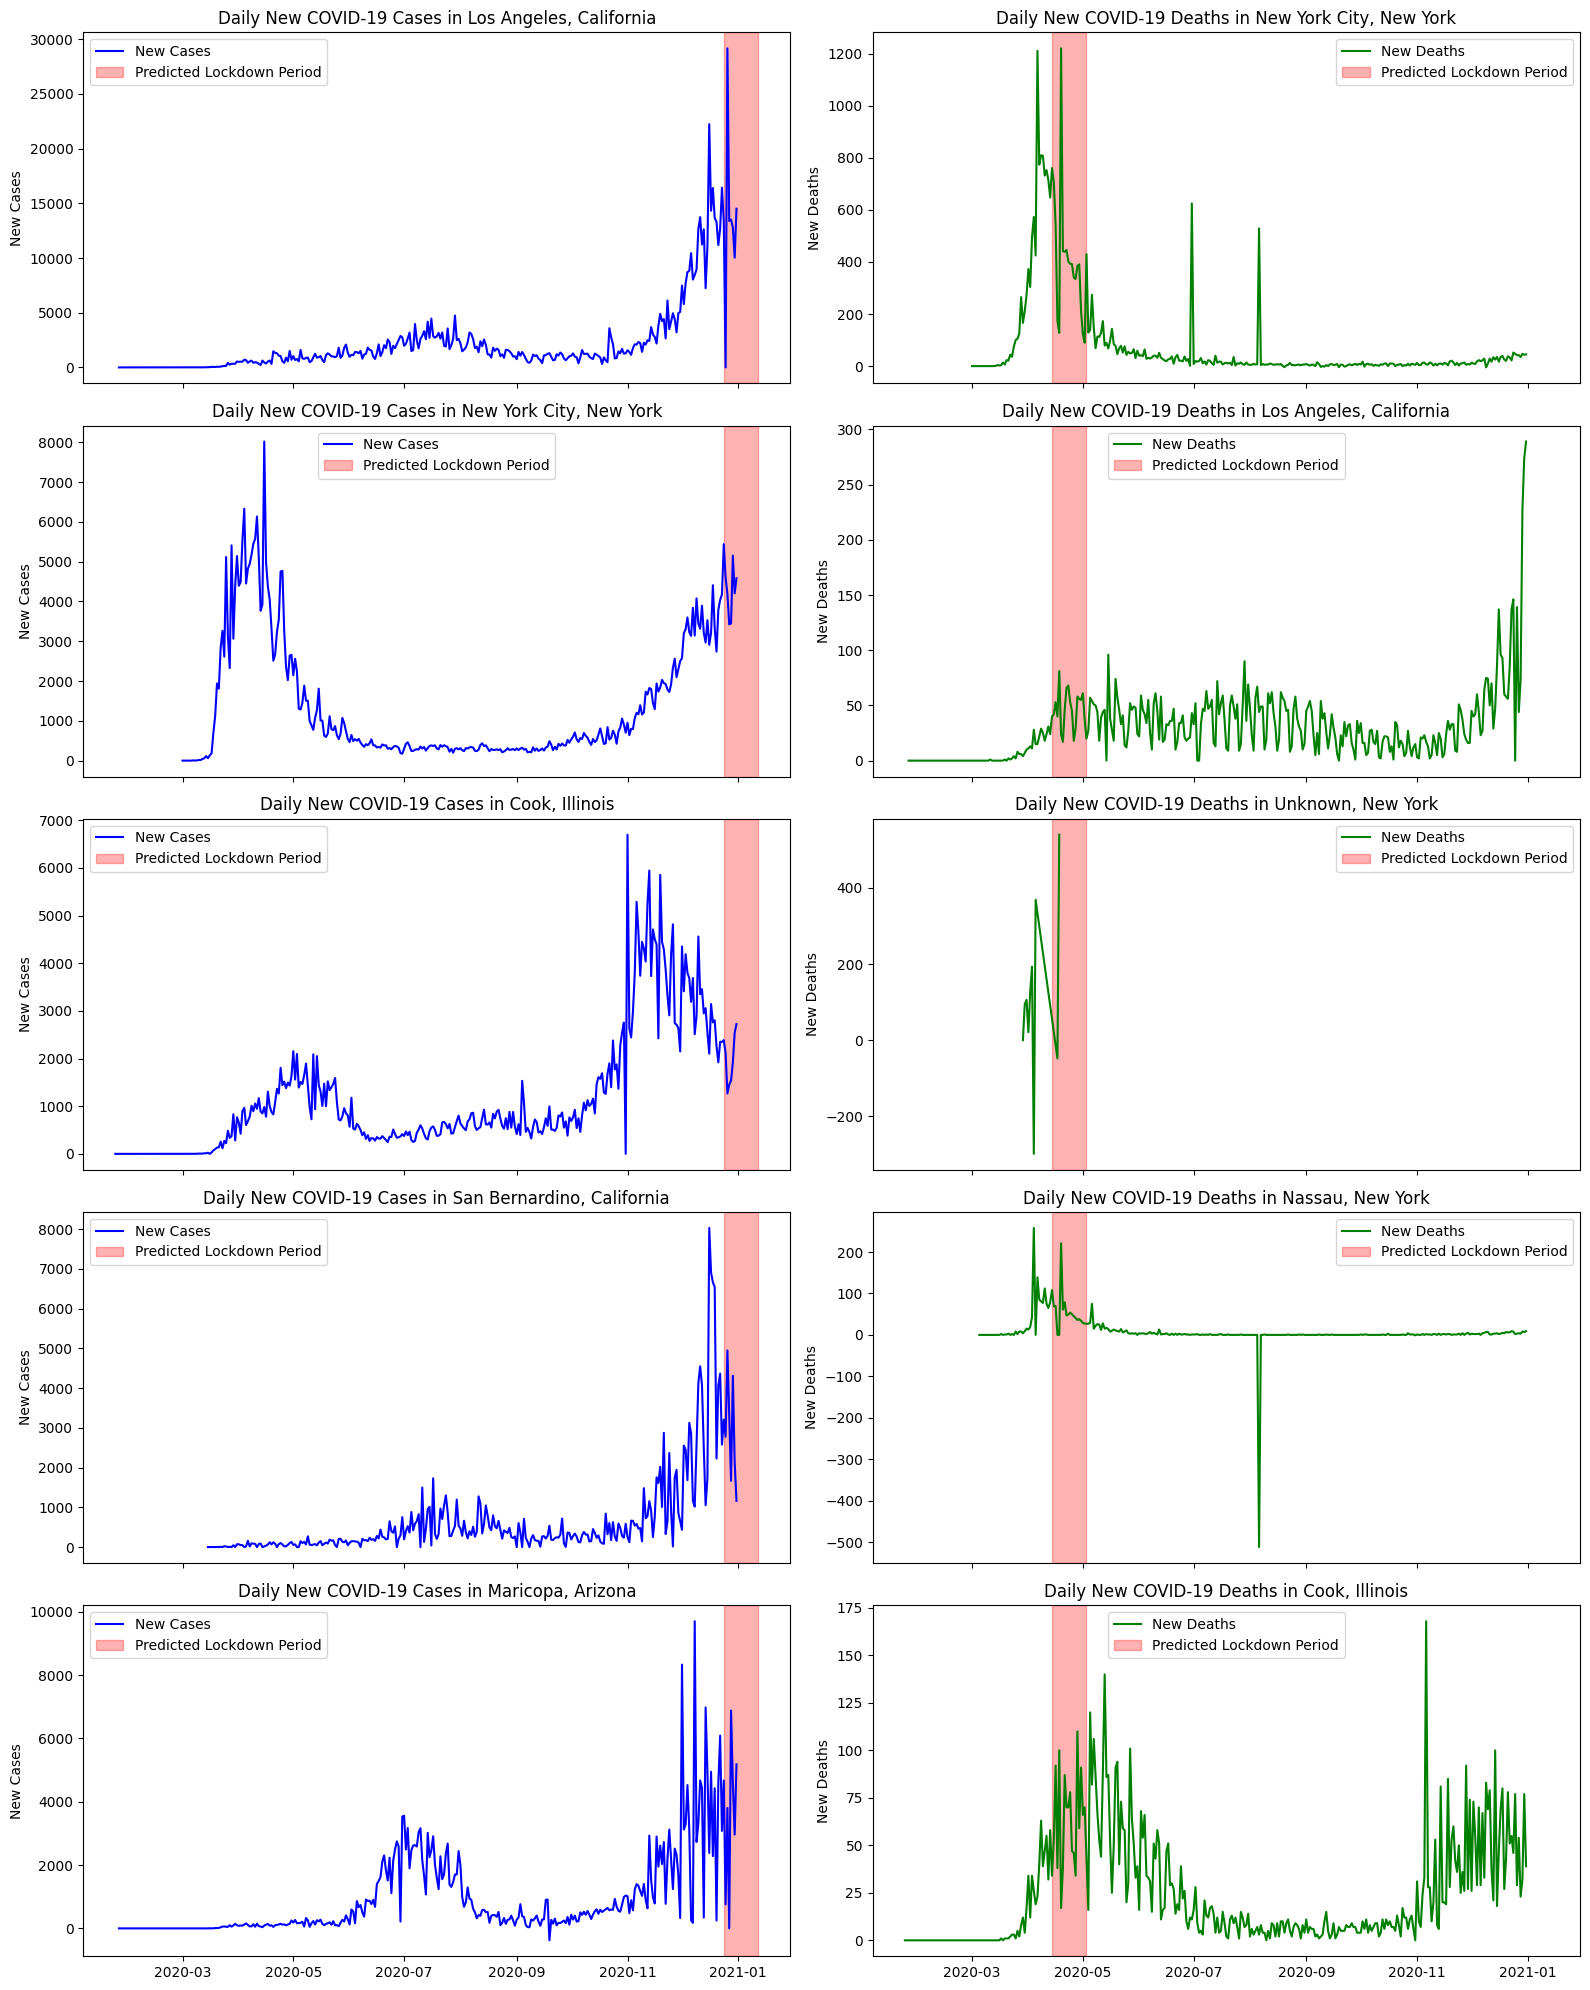

In [13]:
import matplotlib.pyplot as plt

# Identify the top 5 counties with the highest significant increases in cases and deaths
top_cases_counties = data.groupby(['county', 'state'])['14d_rolling_avg_cases'].max().nlargest(5).index
top_deaths_counties = data.groupby(['county', 'state'])['14d_rolling_avg_deaths'].max().nlargest(5).index

# Plotting the data for the top 5 counties with the highest significant increases
fig, axs = plt.subplots(5, 2, figsize=(16, 20), sharex=True)

for i, (county, state) in enumerate(top_cases_counties):
    county_data = data[(data['county'] == county) & (data['state'] == state)]
    axs[i, 0].plot(county_data['date'], county_data['new_cases'], label='New Cases', color='blue')
    axs[i, 0].axvspan(lockdown_start_cases, lockdown_end_cases, color='red', alpha=0.3, label='Predicted Lockdown Period')
    axs[i, 0].set_title(f'Daily New COVID-19 Cases in {county}, {state}')
    axs[i, 0].set_ylabel('New Cases')
    axs[i, 0].legend()

for i, (county, state) in enumerate(top_deaths_counties):
    county_data = data[(data['county'] == county) & (data['state'] == state)]
    axs[i, 1].plot(county_data['date'], county_data['new_deaths'], label='New Deaths', color='green')
    axs[i, 1].axvspan(lockdown_start_deaths, lockdown_end_deaths, color='red', alpha=0.3, label='Predicted Lockdown Period')
    axs[i, 1].set_title(f'Daily New COVID-19 Deaths in {county}, {state}')
    axs[i, 1].set_ylabel('New Deaths')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


In [15]:
!pip install geopandas 

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.1/1.1 MB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 6.1/6.1 MB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 22.9/22.9 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 7.0 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
#Future Scope

In [20]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Load the shapefile containing US county geometries
# shapefile_path = 'States_shapefile.shp'  # Update with the path to your shapefile
# us_counties = gpd.read_file(shapefile_path)

# # Filter the shapefile to include only the counties where lockdowns are predicted
# lockdown_counties = us_counties[us_counties['county_name'].isin(predicted_lockdown_counties)]

# # Plot the map of the USA with all counties
# fig, ax = plt.subplots(figsize=(12, 8))
# us_counties.plot(ax=ax, color='lightgray', edgecolor='black')

# # Overlay the lockdown counties on top of the map and highlight them in red
# lockdown_counties.plot(ax=ax, color='red')

# # Set plot title and labels
# ax.set_title('USA Map with Lockdown Counties Highlighted')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# # Show the plot
# plt.show()
